In [15]:
import pandas as pd
import numpy as np
import h2o
import lime
import optuna


from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.decomposition import PCA  # Principal component
from sklearn.linear_model import LinearRegression, Ridge


import lightgbm as lgb
from catboost import CatBoostRegressor
from h2o.automl import H2OAutoML as ml
from lime import lime_tabular

from functions.datacleaning import MoscowHousing as mh
from functions.clean import revert, write_predictions
from functions.distance import get_distance_coordinates, norm_features, PCA_plot

import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')

In [17]:
XTrain = pd.read_csv("../data/train_prepared_category_3.csv")
XTest = pd.read_csv("../data/test_prepared_category_3.csv")

In [18]:
X_Train = XTrain.copy()
y_Train = XTrain["price"].copy()
y_Train = np.log(y_Train)  # use ln-scores to train

X_Test = XTest.copy()
drop_features = ["Unnamed: 0",
                 "id",
                 "street", 
                 "address"]
X_Train = X_Train.drop(drop_features, axis=1)
X_Train = X_Train.drop("price", axis=1)
X_Test = X_Test.drop(drop_features, axis=1)

In [19]:
#X_Train.info()

In [20]:
# STACKING

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lgbm', lgb.LGBMRegressor(num_leaves=25,
                                       max_depth=15, 
                                       random_state=42,
                                       metric='mse',
                                       n_jobs=4, 
                                       n_estimators=3000,
                                       colsample_bytree=0.7,
                                       subsample=0.9,
                                       learning_rate=0.05)))
    level0.append(('cat', CatBoostRegressor(n_estimators=1000,
                                      learning_rate=0.008,
                                      thread_count=-1,
                                      depth=7,
                                      silent=True,
                                      random_seed=42,
                                      bagging_temperature=0.2)))
    level0.append(('rf',RandomForestRegressor(n_estimators=1000,
                                         criterion='mse',
                                         max_depth=None,
                                         #min_samples_split=2,
                                         #min_samples_leaf=2,
                                         min_weight_fraction_leaf=0.0,
                                         max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         bootstrap=True,
                                         oob_score=False,
                                         n_jobs=None,
                                         random_state=42,
                                         verbose=0,
                                         warm_start=False,
                                         ccp_alpha=0.0,
                                         max_samples=None)))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, 
                              final_estimator=level1, 
                              cv=5)
    return model


def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10,
                       n_repeats= 3,
                       random_state=42)

    score = cross_val_score(model, X, y, 
                            scoring="neg_mean_absolute_error", 
                            cv=cv,
                            n_jobs=-1,
                            error_score="raise")
    return score

def get_models():
    models = {}

    #models["knn"] = KNeighborsRegressor()
    
    models["lgbm"] = lgb.LGBMRegressor(num_leaves=25,
                                       max_depth=15, 
                                       random_state=42,
                                       metric='mse',
                                       n_jobs=4, 
                                       n_estimators=3000,
                                       colsample_bytree=0.7,
                                       subsample=0.9,
                                       learning_rate=0.05)
    
    models["cat"] = CatBoostRegressor(n_estimators=1000,
                                      learning_rate=0.008,
                                      thread_count=-1,
                                      depth=7,
                                      silent=True,
                                      random_seed=42,
                                      bagging_temperature=0.2)
    
    models["rf"] = RandomForestRegressor(n_estimators=1000,
                                         criterion='mse',
                                         max_depth=None,
                                         #min_samples_split=2,
                                         #min_samples_leaf=2,
                                         min_weight_fraction_leaf=0.0,
                                         max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         bootstrap=True,
                                         oob_score=False,
                                         n_jobs=None,
                                         random_state=42,
                                         verbose=0,
                                         warm_start=False,
                                         ccp_alpha=0.0,
                                         max_samples=None)
    
    models['stacking'] = get_stacking()
    
    return models

In [21]:
y = y_Train.copy()
X = X_Train.copy()

X = X.drop(["constructed"], axis=1)

models = get_models()

for k, o in models.items():

    print(k)
    print(o)


lgbm
LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=15,
              metric='mse', n_estimators=3000, n_jobs=4, num_leaves=25,
              random_state=42, subsample=0.9)
cat
rf
RandomForestRegressor(n_estimators=1000, random_state=42)
stacking
StackingRegressor(cv=5,
                  estimators=[('lgbm',
                               LGBMRegressor(colsample_bytree=0.7,
                                             learning_rate=0.05, max_depth=15,
                                             metric='mse', n_estimators=3000,
                                             n_jobs=4, num_leaves=25,
                                             random_state=42, subsample=0.9)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x7fc7d98584c0>),
                              ('rf',
                               RandomForestRegressor(n_estimators=1000,
                                                     rando

>lgbm -0.130 (0.003)
>cat -0.203 (0.004)
>rf -0.153 (0.004)
>stacking -0.128 (0.003)


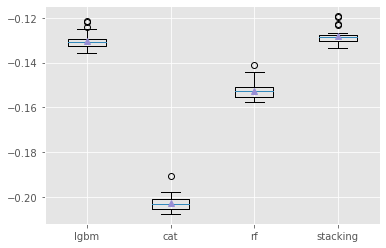

In [22]:
results = []
names = []
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [23]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 0, 10)
    intercept = trial.suggest_categorical("fit_intercept", [True, False])
    tol = trial.suggest_float("tol", 0.001, 0.01, log=False)
    solver = trial.suggest_categorical("solver", ["auto", "svd","cholesky", "lsqr", "saga", "sag"])

    ## Create Model
    regressor = Ridge(alpha=alpha,fit_intercept=intercept,tol=tol,solver=solver)
    ## Fit Model
    regressor.fit(X_train, Y_train)

    return mean_squared_error(Y_test, regressor.predict(X_test))

In [24]:
y = y_Train.copy()
X = X_Train.copy()
X = X.drop(["constructed"], axis=1)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [26]:
study = optuna.create_study(study_name="RidgeRegression")
study.optimize(objective, n_trials=15)

[I 2021-11-17 01:53:46,457] A new study created in memory with name: RidgeRegression
[I 2021-11-17 01:53:46,548] Trial 0 finished with value: 1.1711571697565437 and parameters: {'alpha': 4.936527656860949, 'fit_intercept': False, 'tol': 0.003459531144392265, 'solver': 'lsqr'}. Best is trial 0 with value: 1.1711571697565437.
[I 2021-11-17 01:53:46,683] Trial 1 finished with value: 0.1626303804884957 and parameters: {'alpha': 0.4307621281594931, 'fit_intercept': True, 'tol': 0.003924055028038361, 'solver': 'svd'}. Best is trial 1 with value: 0.1626303804884957.
[I 2021-11-17 01:53:46,705] Trial 2 finished with value: 0.7882615051319328 and parameters: {'alpha': 9.515591201352867, 'fit_intercept': True, 'tol': 0.0024813005683958717, 'solver': 'lsqr'}. Best is trial 1 with value: 0.1626303804884957.
[I 2021-11-17 01:53:46,986] Trial 3 finished with value: 0.9849317349875538 and parameters: {'alpha': 7.867537652051948, 'fit_intercept': False, 'tol': 0.005337698818336456, 'solver': 'sag'}. B

In [27]:
study.best_params 

{'alpha': 6.249955540030098,
 'fit_intercept': True,
 'tol': 0.008495543604325128,
 'solver': 'cholesky'}

In [29]:
print("Best Params : {}".format(study.best_params))

print("\nBest MSE : {}".format(study.best_value))

Best Params : {'alpha': 6.249955540030098, 'fit_intercept': True, 'tol': 0.008495543604325128, 'solver': 'cholesky'}

Best MSE : 0.16235170041233393


In [30]:
ridge = Ridge(**study.best_params)
ridge.fit(X_train, Y_train)

Ridge(alpha=6.249955540030098, solver='cholesky', tol=0.008495543604325128)

In [31]:
print("Ridge Regression MSE on Train Dataset : {}".format(mean_squared_error(Y_train, ridge.predict(X_train))))
print("Ridge Regression MSE on Test  Dataset : {}".format(mean_squared_error(Y_test, ridge.predict(X_test))))

Ridge Regression MSE on Train Dataset : 0.1581142868870628
Ridge Regression MSE on Test  Dataset : 0.16235170041233393


In [ ]:
study.optimize(objective, n_trials=10)

In [ ]:
def objective(trial):
    kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
    c=trial.suggest_float("C",0.1,3.0,log=True)
    gamma=trial.suggest_categorical('gamma',['auto','scale'])
    degree=trial.suggest_int("degree",1,3,log=True)
    model =SVR(kernel=kernel,degree=degree,gamma=gamma,C=c)
    model.fit(X_train,y_train)
    accuracy = model.score(X_test,y_test)
    return accuracy
model =SVR(kernel=kernel,degree=degree,gamma=gamma,C=c)
study = op.create_study(direction="maximize")
study.optimize(objective, n_trials=20,n_jobs=-1)